Adjusting ResNet architecture for use with CIFAR-10 dataset. Training ResNet-18 from scratch.

Check the GPU assigned:

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed May  5 06:10:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# install  PyTorch
!pip install torch torchvision

In [ ]:
import torch
torch.__version__

'1.8.1+cu101'

In [1]:
from torchvision.datasets import CIFAR10
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
import time as t
from torch import nn, optim
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import DataLoader

from torch import Tensor
import torch.nn as nn
#from .utils import load_state_dict_from_url
from typing import Type, Any, Callable, Union, List, Optional

## Define the model

https://pytorch.org/vision/stable/_modules/torchvision/models/resnet.html

ResNet is automatically set up for ImageNet, which has 1000 classes, with CIFAR-10, we only have 10.

In [2]:
__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}

In [3]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 10,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(self, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
    arch: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

In [4]:
def resnet18(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)

In [5]:
def resnet34(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)

In [6]:
def resnet50(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)

In [7]:
def resnet101(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)

In [8]:
def resnet152(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)

In [9]:
def resnext50_32x4d(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)

In [10]:
def resnext101_32x8d(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)

In [11]:
def wide_resnet50_2(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_.

    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)

In [12]:
def wide_resnet101_2(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_.

    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)

In [13]:
# select the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# define the model
model = resnet18(False, True).to(device)

In [14]:
# view the details of the model
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Set variables

In [ ]:
epochs = 50
batch_size = 32
learning_rate = 0.001

## Download data
Loading Cifar-10 data. Images need to be rescaled and numbers normalised.

In [ ]:
def get_data_loaders(train_batch_size, val_batch_size):
    #cifar10 = CIFAR10(download=True, train=True, root=".").train_data.float()
    
    data_transform = Compose([ Resize((224, 224)),ToTensor(), Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])])

    train_loader = DataLoader(CIFAR10(download=True, root=".", transform=data_transform, train=True),
                              batch_size=train_batch_size, shuffle=True)

    val_loader = DataLoader(CIFAR10(download=False, root=".", transform=data_transform, train=False),
                            batch_size=val_batch_size, shuffle=True)
    return train_loader, val_loader

In [ ]:
# load the data to variables
train_loader, val_loader = get_data_loaders(batch_size, batch_size)


Extracting ./cifar-10-python.tar.gz to .


## Run the model

In [ ]:
# helper function
def calculate_metric(metric_fn, true_y, pred_y):
  # multi class problems need to have averaging methods
  if "average" in inspect.getfullargspec(metric_fn).args:
    return metric_fn(true_y, pred_y, average="macro")
  else:
    return metric_fn(true_y, pred_y)
    
def print_scores(p, r, f1, a, batch_size):
  # a utility printing mfunction
  for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
    print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

In [ ]:
# import datetime to include in submission
from datetime import datetime

In [ ]:
start_ts = t.time()

now_start = datetime.now()
print(f"Starting training with {epochs} epochs on {now_start.strftime('%d/%m/%Y %H:%M:%S')}")


losses_train = []
losses_val = []
accuracies = []
times = []
# loss function, corss entropy works well for multi-class problems
loss_function = nn.CrossEntropyLoss()
# an optimiser
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = optim.Adadelta(model.parameters())

batches = len(train_loader)
val_batches = len(val_loader)

# training loop + eval loop
for epoch in range(epochs):
    start_epoch = t.time()
    total_loss = 0
    # progress bar
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)

    # ----------------- TRAINING  -------------------- 
    # set model to training
    model.train()
    
    for i, data in progress:
        X, y = data[0].to(device), data[1].to(device)
        
        # training step for single batch
        model.zero_grad()
        outputs = model(X)
        loss = loss_function(outputs, y)

        loss.backward()
        optimizer.step()

        # getting training quality data
        current_loss = loss.item()
        total_loss += current_loss

        # updating progress bar
        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))

    # releasing unnecessary memory in GPU 
    if torch.cuda.is_available():
      torch.cuda.empty_cache()
    
    # ----------------- VALIDATION  -----------------
    val_losses = 0
    precision, recall, f1, accuracy = [], [], [], []
    
    # set model to evaluating (testing)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            X, y = data[0].to(device), data[1].to(device)
            outputs = model(X) # this gets the prediction from the network
            val_losses += loss_function(outputs, y)

            predicted_classes = torch.max(outputs, 1)[1] # get class from networks prediction
            
            # calculate P/R/F1/A metrics for batch
            for acc, metric in zip((precision, recall, f1, accuracy), 
                                   (precision_score, recall_score, f1_score, accuracy_score)):
                acc.append(
                    calculate_metric(metric, y.cpu(), predicted_classes.cpu())
                )
        
    print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
    print_scores(precision, recall, f1, accuracy, val_batches)
    losses_train.append(total_loss/batches) # for plotting learning curve
    losses_val.append(float((val_losses/val_batches).cpu()))
    times.append((t.time() - start_epoch)/60)
    accuracies.append(sum(accuracy)/len(accuracy))
print("Training losses:")
print(losses_train)
print("Validation losses:")
print(losses_val)
print("Accuracies:")
print(accuracies)
print()
now_end = datetime.now()
print(f"Training finished at {now_end.strftime('%d/%m/%Y %H:%M:%S')}")
print(f"Training time: {(t.time()-start_ts)/60} minutes")

Starting training with 50 epochs on 05/05/2021 06:10:40


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50, training loss: 1.3589703408251645, validation loss: 1.1269489526748657
	     precision: 0.6089
	        recall: 0.6065
	            F1: 0.5635
	      accuracy: 0.6196



Epoch 2/50, training loss: 0.8300259582560107, validation loss: 0.8499131798744202
	     precision: 0.7080
	        recall: 0.6905
	            F1: 0.6586
	      accuracy: 0.7075



Epoch 3/50, training loss: 0.6228314199397293, validation loss: 0.6435456871986389
	     precision: 0.7709
	        recall: 0.7674
	            F1: 0.7392
	      accuracy: 0.7807



Epoch 4/50, training loss: 0.4986291004729744, validation loss: 0.5642417073249817
	     precision: 0.7977
	        recall: 0.7965
	            F1: 0.7713
	      accuracy: 0.8053



Epoch 5/50, training loss: 0.3868166037900129, validation loss: 0.5514243841171265
	     precision: 0.8090
	        recall: 0.8046
	            F1: 0.7813
	      accuracy: 0.8151



Epoch 6/50, training loss: 0.30048529535736973, validation loss: 0.5215427875518799
	     precision: 0.8177
	        recall: 0.8126
	            F1: 0.7920
	      accuracy: 0.8256



Epoch 7/50, training loss: 0.2139573813840909, validation loss: 0.5488452911376953
	     precision: 0.8240
	        recall: 0.8235
	            F1: 0.8004
	      accuracy: 0.8354



Epoch 8/50, training loss: 0.15501144801678227, validation loss: 0.5474193692207336
	     precision: 0.8333
	        recall: 0.8306
	            F1: 0.8107
	      accuracy: 0.8429



Epoch 9/50, training loss: 0.11275315392012836, validation loss: 0.606637716293335
	     precision: 0.8270
	        recall: 0.8268
	            F1: 0.8041
	      accuracy: 0.8378



Epoch 10/50, training loss: 0.0920118439188245, validation loss: 0.6529080271720886
	     precision: 0.8318
	        recall: 0.8279
	            F1: 0.8099
	      accuracy: 0.8371



Epoch 11/50, training loss: 0.08201307348192116, validation loss: 0.6534110903739929
	     precision: 0.8247
	        recall: 0.8236
	            F1: 0.8037
	      accuracy: 0.8410



Epoch 12/50, training loss: 0.06433066153798732, validation loss: 0.7017935514450073
	     precision: 0.8345
	        recall: 0.8284
	            F1: 0.8100
	      accuracy: 0.8384



Epoch 13/50, training loss: 0.05576238259705891, validation loss: 0.7028295397758484
	     precision: 0.8302
	        recall: 0.8297
	            F1: 0.8087
	      accuracy: 0.8421



Epoch 14/50, training loss: 0.05293414213260253, validation loss: 0.6605419516563416
	     precision: 0.8408
	        recall: 0.8398
	            F1: 0.8198
	      accuracy: 0.8503



Epoch 15/50, training loss: 0.04854184952948492, validation loss: 0.6980024576187134
	     precision: 0.8311
	        recall: 0.8303
	            F1: 0.8108
	      accuracy: 0.8455



Epoch 16/50, training loss: 0.04672621472395173, validation loss: 0.7929754853248596
	     precision: 0.8304
	        recall: 0.8281
	            F1: 0.8073
	      accuracy: 0.8371



Epoch 17/50, training loss: 0.036634048004380505, validation loss: 0.7526848316192627
	     precision: 0.8323
	        recall: 0.8264
	            F1: 0.8077
	      accuracy: 0.8389



Epoch 18/50, training loss: 0.03857645729102023, validation loss: 0.7313515543937683
	     precision: 0.8335
	        recall: 0.8346
	            F1: 0.8120
	      accuracy: 0.8459



Epoch 19/50, training loss: 0.03631449426748792, validation loss: 0.7381693124771118
	     precision: 0.8366
	        recall: 0.8350
	            F1: 0.8158
	      accuracy: 0.8509



Epoch 20/50, training loss: 0.0315043464167804, validation loss: 0.860247015953064
	     precision: 0.8210
	        recall: 0.8246
	            F1: 0.8007
	      accuracy: 0.8398



Epoch 21/50, training loss: 0.028850518681491473, validation loss: 0.7981409430503845
	     precision: 0.8435
	        recall: 0.8400
	            F1: 0.8212
	      accuracy: 0.8485



Epoch 22/50, training loss: 0.03057283103480097, validation loss: 0.7479513883590698
	     precision: 0.8385
	        recall: 0.8411
	            F1: 0.8186
	      accuracy: 0.8521



Epoch 23/50, training loss: 0.030709307290276454, validation loss: 0.7610653042793274
	     precision: 0.8367
	        recall: 0.8357
	            F1: 0.8161
	      accuracy: 0.8492



Epoch 24/50, training loss: 0.022708359948372538, validation loss: 0.8592219948768616
	     precision: 0.8283
	        recall: 0.8269
	            F1: 0.8070
	      accuracy: 0.8437



Epoch 25/50, training loss: 0.0279766084866945, validation loss: 0.769671618938446
	     precision: 0.8432
	        recall: 0.8411
	            F1: 0.8225
	      accuracy: 0.8503



Epoch 26/50, training loss: 0.022496558521099247, validation loss: 0.8086009621620178
	     precision: 0.8373
	        recall: 0.8373
	            F1: 0.8167
	      accuracy: 0.8491



Epoch 27/50, training loss: 0.02369867677511265, validation loss: 0.8630202412605286
	     precision: 0.8381
	        recall: 0.8381
	            F1: 0.8189
	      accuracy: 0.8504



Epoch 28/50, training loss: 0.023186918522765606, validation loss: 0.8027164936065674
	     precision: 0.8385
	        recall: 0.8395
	            F1: 0.8183
	      accuracy: 0.8463



Epoch 29/50, training loss: 0.02053075861001772, validation loss: 0.8024431467056274
	     precision: 0.8387
	        recall: 0.8407
	            F1: 0.8194
	      accuracy: 0.8476



Epoch 30/50, training loss: 0.023102165296358827, validation loss: 0.8841071724891663
	     precision: 0.8411
	        recall: 0.8330
	            F1: 0.8157
	      accuracy: 0.8443



Epoch 31/50, training loss: 0.019622848969288804, validation loss: 0.8621622323989868
	     precision: 0.8420
	        recall: 0.8428
	            F1: 0.8224
	      accuracy: 0.8516



Epoch 32/50, training loss: 0.016619301566199996, validation loss: 0.8334736824035645
	     precision: 0.8368
	        recall: 0.8401
	            F1: 0.8192
	      accuracy: 0.8541



Epoch 33/50, training loss: 0.022581127650388548, validation loss: 0.7772594690322876
	     precision: 0.8473
	        recall: 0.8467
	            F1: 0.8277
	      accuracy: 0.8567



Epoch 34/50, training loss: 0.017192448372390534, validation loss: 0.8097708225250244
	     precision: 0.8468
	        recall: 0.8459
	            F1: 0.8262
	      accuracy: 0.8577



Epoch 35/50, training loss: 0.017466229184435307, validation loss: 0.8504281640052795
	     precision: 0.8415
	        recall: 0.8408
	            F1: 0.8202
	      accuracy: 0.8495



Epoch 36/50, training loss: 0.01709744531904404, validation loss: 0.7990045547485352
	     precision: 0.8516
	        recall: 0.8477
	            F1: 0.8308
	      accuracy: 0.8598



Epoch 37/50, training loss: 0.013055496385465316, validation loss: 0.8951325416564941
	     precision: 0.8348
	        recall: 0.8289
	            F1: 0.8110
	      accuracy: 0.8460



Epoch 38/50, training loss: 0.018997682282517366, validation loss: 0.8299381732940674
	     precision: 0.8458
	        recall: 0.8433
	            F1: 0.8249
	      accuracy: 0.8552



Epoch 39/50, training loss: 0.015354026728134554, validation loss: 0.8575001358985901
	     precision: 0.8408
	        recall: 0.8414
	            F1: 0.8218
	      accuracy: 0.8520



Epoch 40/50, training loss: 0.014972108572944919, validation loss: 0.8505944013595581
	     precision: 0.8442
	        recall: 0.8400
	            F1: 0.8235
	      accuracy: 0.8537



Epoch 41/50, training loss: 0.013053092322605913, validation loss: 0.8365851640701294
	     precision: 0.8382
	        recall: 0.8384
	            F1: 0.8201
	      accuracy: 0.8535



Epoch 42/50, training loss: 0.014246958099572826, validation loss: 0.8563436269760132
	     precision: 0.8351
	        recall: 0.8363
	            F1: 0.8167
	      accuracy: 0.8488



Epoch 43/50, training loss: 0.013677290413049452, validation loss: 0.8284513354301453
	     precision: 0.8487
	        recall: 0.8492
	            F1: 0.8301
	      accuracy: 0.8574



Epoch 44/50, training loss: 0.012201561144959006, validation loss: 0.8648608326911926
	     precision: 0.8431
	        recall: 0.8406
	            F1: 0.8224
	      accuracy: 0.8561



Epoch 45/50, training loss: 0.013994926296021486, validation loss: 0.9055142402648926
	     precision: 0.8331
	        recall: 0.8347
	            F1: 0.8156
	      accuracy: 0.8498



Epoch 46/50, training loss: 0.011261506453046343, validation loss: 0.8488938212394714
	     precision: 0.8451
	        recall: 0.8458
	            F1: 0.8266
	      accuracy: 0.8586



Epoch 47/50, training loss: 0.013517320432449239, validation loss: 0.8704410791397095
	     precision: 0.8447
	        recall: 0.8462
	            F1: 0.8256
	      accuracy: 0.8554



Epoch 48/50, training loss: 0.013240744045189322, validation loss: 0.851803719997406
	     precision: 0.8457
	        recall: 0.8440
	            F1: 0.8266
	      accuracy: 0.8585



Epoch 49/50, training loss: 0.010783777822289715, validation loss: 0.8942704200744629
	     precision: 0.8396
	        recall: 0.8371
	            F1: 0.8201
	      accuracy: 0.8522



Epoch 50/50, training loss: 0.012522850538179298, validation loss: 0.8681145906448364
	     precision: 0.8498
	        recall: 0.8466
	            F1: 0.8286
	      accuracy: 0.8587
Training losses:
[1.3589703408251645, 0.8300259582560107, 0.6228314199397293, 0.4986291004729744, 0.3868166037900129, 0.30048529535736973, 0.2139573813840909, 0.15501144801678227, 0.11275315392012836, 0.0920118439188245, 0.08201307348192116, 0.06433066153798732, 0.05576238259705891, 0.05293414213260253, 0.04854184952948492, 0.04672621472395173, 0.036634048004380505, 0.03857645729102023, 0.03631449426748792, 0.0315043464167804, 0.028850518681491473, 0.03057283103480097, 0.030709307290276454, 0.022708359948372538, 0.0279766084866945, 0.022496558521099247, 0.02369867677511265, 0.023186918522765606, 0.02053075861001772, 0.023102165296358827, 0.019622848969288804, 0.016619301566199996, 0.022581127650388548, 0.017192448372390534, 0.017466229184435307, 0.01709744531904404, 0.013055496385465316, 0.0189976822825173

Plot the training and validation loss

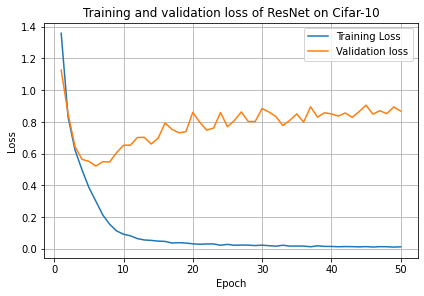

In [ ]:
import matplotlib.pyplot as plt

x = range(1,epochs+1)

plt.plot(x, losses_train, label = "Training Loss")
plt.plot(x, losses_val, label = "Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=1)
plt.grid(True)
plt.tight_layout()
plt.title('Training and validation loss of ResNet on Cifar-10')
plt.savefig('Cifar10_ResNet_Train.png')
plt.show()

Plot accuracy

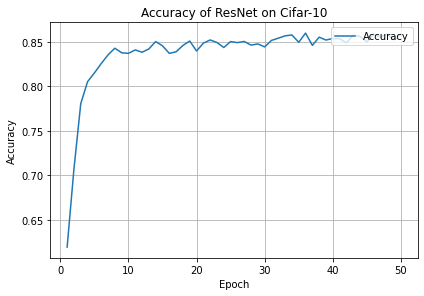

In [ ]:
import matplotlib.pyplot as plt

x = range(1,epochs+1)

plt.plot(x, accuracies, label = "Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=1)
plt.grid(True)
plt.tight_layout()
plt.title('Accuracy of ResNet on Cifar-10')
plt.savefig('Cifar10_ResNet_Accuracy.png')
plt.show()

Export values for loss and accuracy to a CSV file for later plotting/evaluation.

In [ ]:
import pandas as pd
data = {'Data': 'Cifar-10', 'Model': 'ResNet', 'Epoch': x, 'Training loss': losses_train,
     'Validation loss': losses_val, 'Accuracy': accuracies, 'Time_per_epoch': times}
df = pd.DataFrame(data)
df.to_csv('Cifar10_ResNet.csv', index=False)

In [ ]:
# save the model
torch.save(model,'ResNet.h5')

In [16]:
# load the trained model
loaded_model = torch.load('ResNet.h5')

## Visualise some predictions

In [17]:
# download validation files
from tensorflow.keras.datasets import cifar10
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
# set up a list of words for labels
labels_word = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

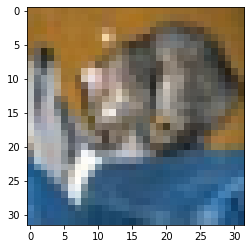

Actual Label: cat
Label: 3


In [20]:
# visualise one sample
sample = 0
image = X_test[sample]
label = int(Y_test[sample])
word_label = labels_word[label]
# plot the sample
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()
print(f'Actual Label: {word_label}')
print(f'Label: {label}')

Load validation again but this time with batch size 1

In [21]:
def get_data_loaders():
    #cifar10 = CIFAR10(download=True, train=True, root=".").train_data.float()
    
    data_transform = Compose([ Resize((224, 224)),ToTensor(), Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])])


    val_loader = DataLoader(CIFAR10(download=True, root=".", transform=data_transform, train=False),
                            batch_size=1, shuffle=False)
    return val_loader

In [22]:
# load the data to variables
val_loader = get_data_loaders()


Extracting ./cifar-10-python.tar.gz to .


Get predictions

In [56]:
import torch.nn.functional as F

# a variavle j to set the number of records I want
j = 0

# a dictionary to keep my results
results = {}

loaded_model.eval()
with torch.no_grad():
  for i, data in enumerate(val_loader):
    X, y = data[0].to(device), data[1].to(device)
    outputs = loaded_model(X) # this gets the prediction from the network
    #val_losses += loss_function(outputs, y)


    predicted_classes = torch.max(outputs, 1)[1] # get class from networks prediction
    y_int = int(y)
    predicted_int = int(predicted_classes)
    predicted = torch.topk(outputs, 5)[1]

    if j<50:
      if y_int != predicted_int:
        print('Prediction')
        print(i)
        print()
        a = torch.topk(outputs, 10)[0]
        b = a.tolist()
        c = torch.FloatTensor(b)
        d = F.softmax(c, dim=1)
        e = d.tolist()
        f = e[0]
        f = [elem*100 for elem in f]
        g = f[0:5]
        h = [ '%.2f' % elem for elem in g ]

        print(f'Actual class: {y}')
        print(f'Predicted class: {predicted_classes}')
        print(f'Top predictions: {predicted.tolist()}')
        record = { 'Actual_class': y_int, 'Predicted': predicted_int, 'Predictions': predicted.tolist(),
                  'Percent': h}
        results[i] = record
        print()
        j += 1

    if j>=50:
      break;

"""           
    # calculate P/R/F1/A metrics for batch
    for acc, metric in zip((precision, recall, f1, accuracy), 
                          (precision_score, recall_score, f1_score, accuracy_score)):
      acc.append(calculate_metric(metric, y.cpu(), predicted_classes.cpu()))
        
print_scores(precision, recall, f1, accuracy, val_batches)
losses_train.append(total_loss/batches) # for plotting learning curve
losses_val.append(float((val_losses/val_batches).cpu()))
accuracies.append(sum(accuracy)/len(accuracy))"""

Prediction
17

Actual class: tensor([7], device='cuda:0')
Predicted class: tensor([3], device='cuda:0')
Top predictions: [[3, 7, 2, 9, 5]]

Prediction
24

Actual class: tensor([5], device='cuda:0')
Predicted class: tensor([4], device='cuda:0')
Top predictions: [[4, 5, 6, 2, 8]]

Prediction
25

Actual class: tensor([2], device='cuda:0')
Predicted class: tensor([9], device='cuda:0')
Top predictions: [[9, 2, 3, 7, 6]]

Prediction
35

Actual class: tensor([2], device='cuda:0')
Predicted class: tensor([8], device='cuda:0')
Top predictions: [[8, 1, 9, 3, 2]]

Prediction
37

Actual class: tensor([1], device='cuda:0')
Predicted class: tensor([9], device='cuda:0')
Top predictions: [[9, 1, 3, 8, 7]]

Prediction
59

Actual class: tensor([6], device='cuda:0')
Predicted class: tensor([3], device='cuda:0')
Top predictions: [[3, 6, 4, 2, 5]]

Prediction
61

Actual class: tensor([3], device='cuda:0')
Predicted class: tensor([5], device='cuda:0')
Top predictions: [[5, 3, 2, 6, 7]]

Prediction
68

Actua

'           \n    # calculate P/R/F1/A metrics for batch\n    for acc, metric in zip((precision, recall, f1, accuracy), \n                          (precision_score, recall_score, f1_score, accuracy_score)):\n      acc.append(calculate_metric(metric, y.cpu(), predicted_classes.cpu()))\n        \nprint_scores(precision, recall, f1, accuracy, val_batches)\nlosses_train.append(total_loss/batches) # for plotting learning curve\nlosses_val.append(float((val_losses/val_batches).cpu()))\naccuracies.append(sum(accuracy)/len(accuracy))'

Visualise them

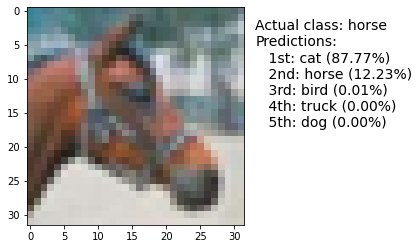

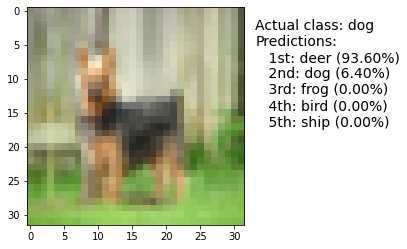

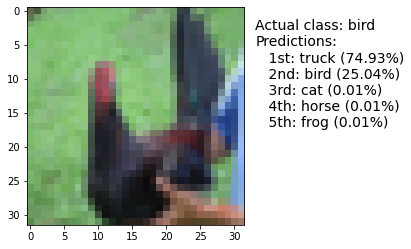

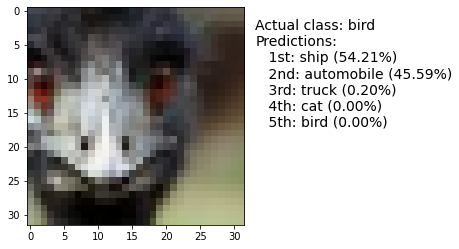

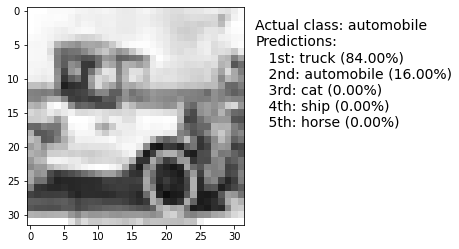

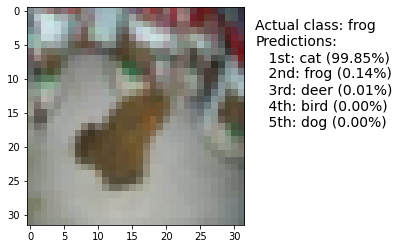

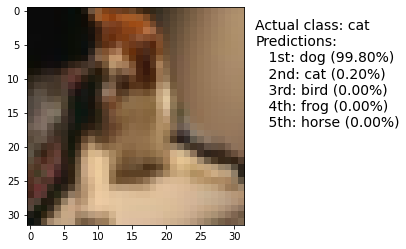

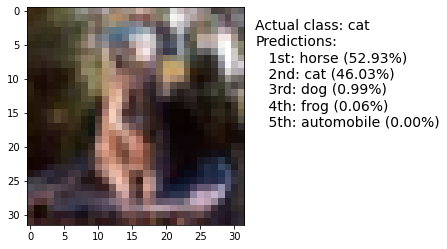

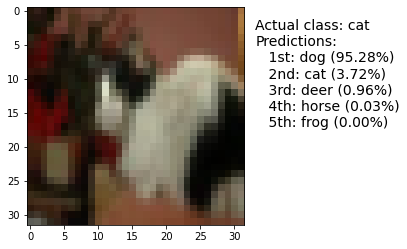

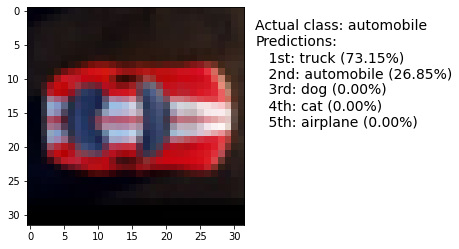

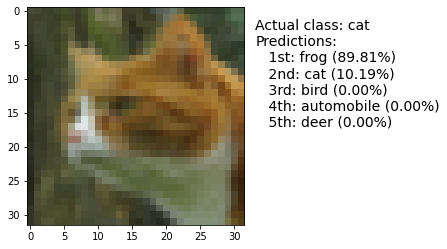

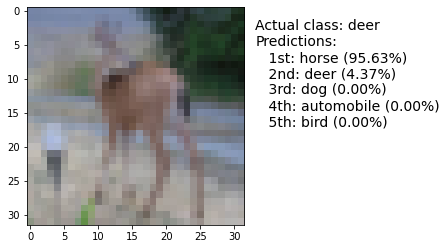

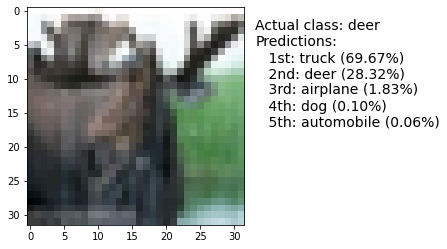

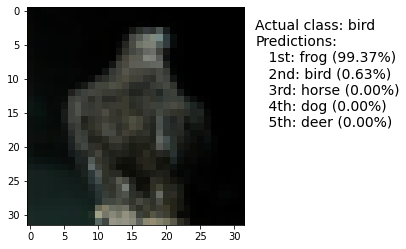

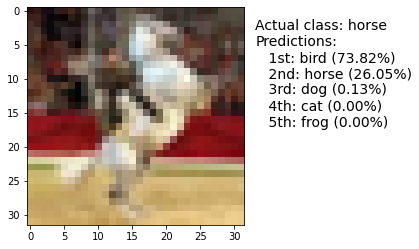

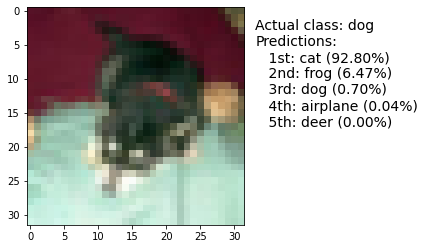

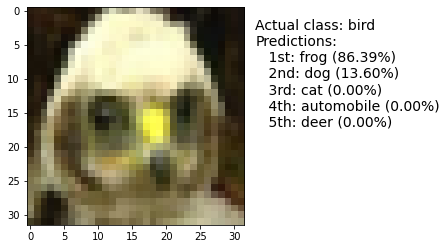

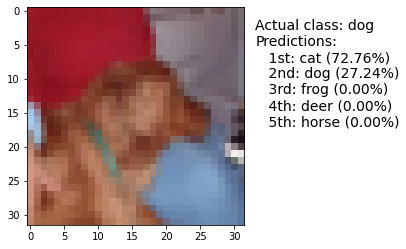

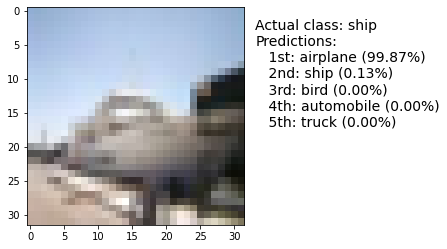

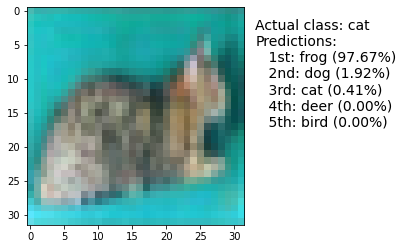

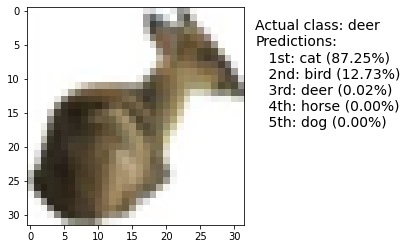

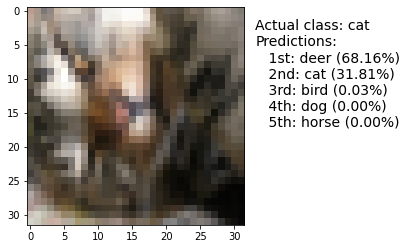

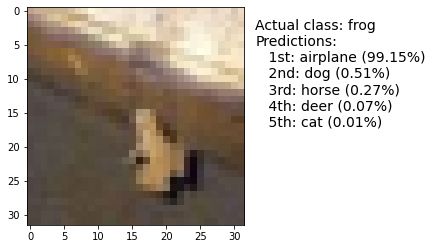

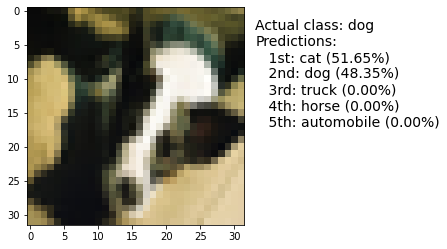

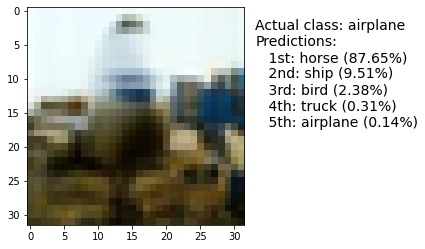

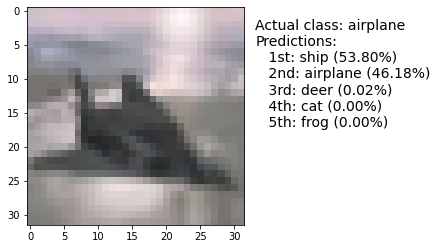

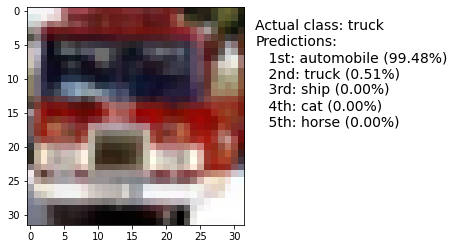

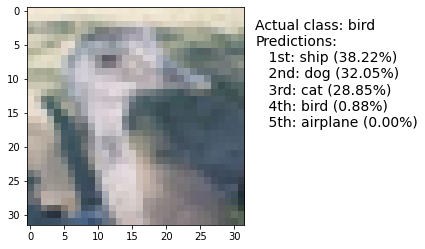

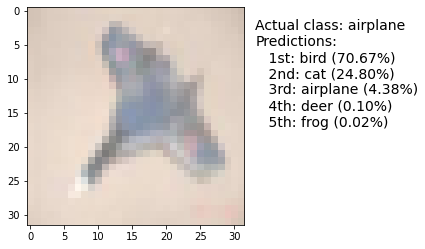

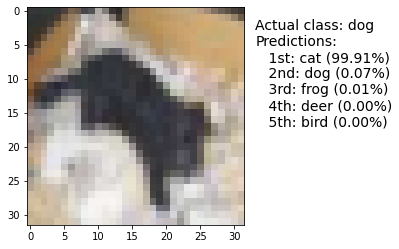

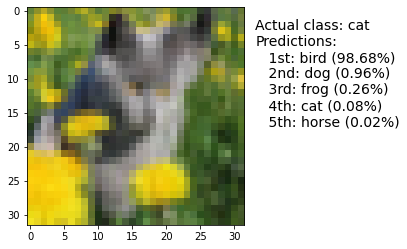

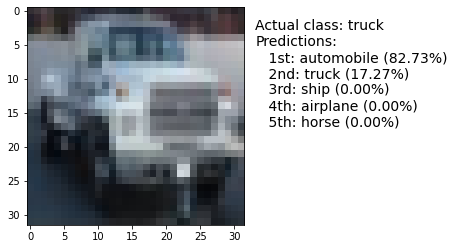

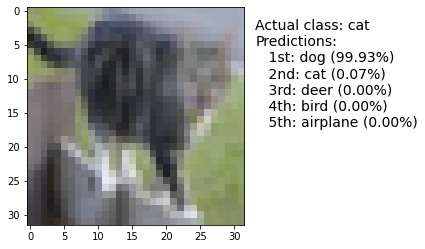

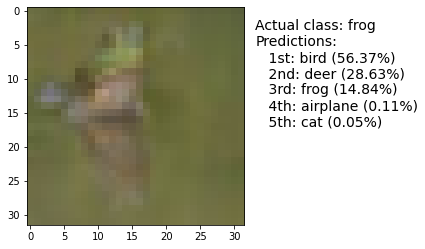

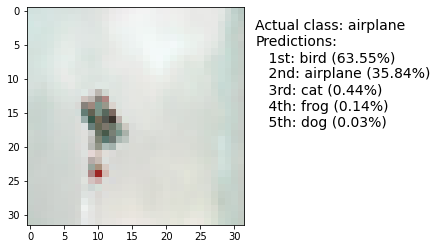

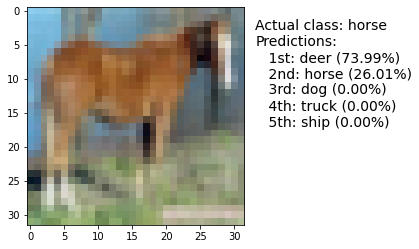

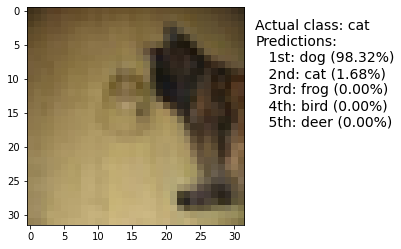

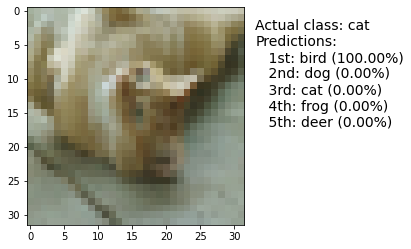

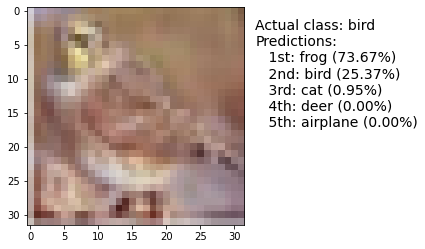

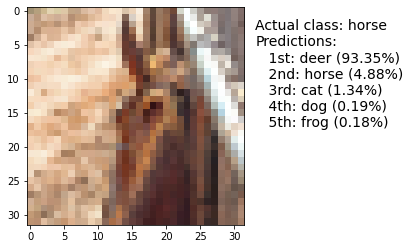

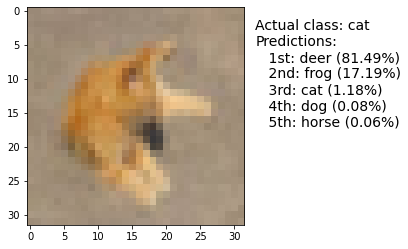

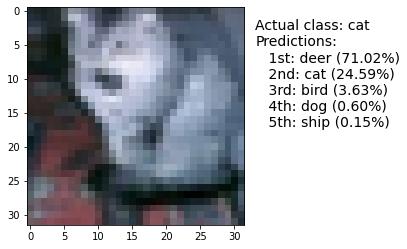

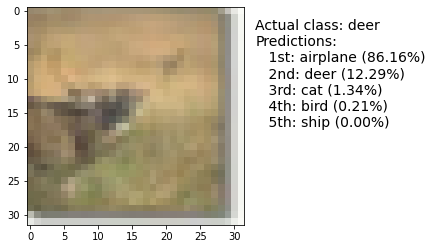

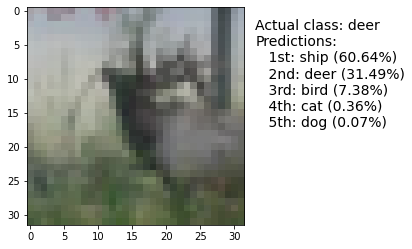

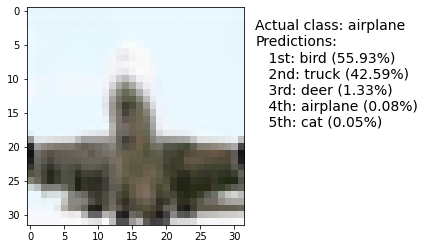

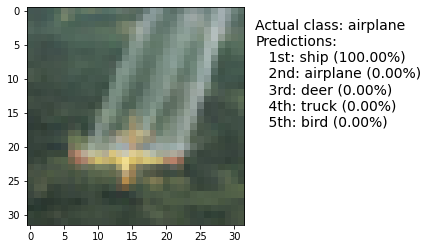

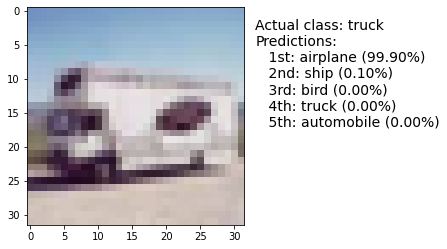

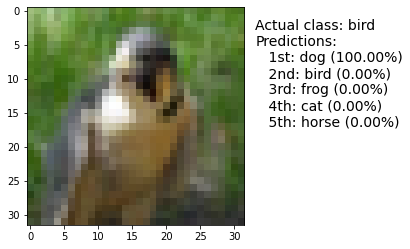

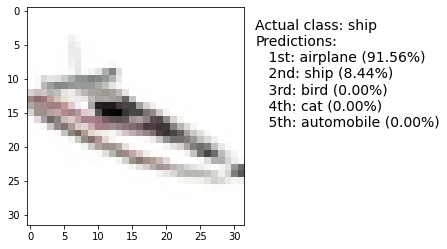

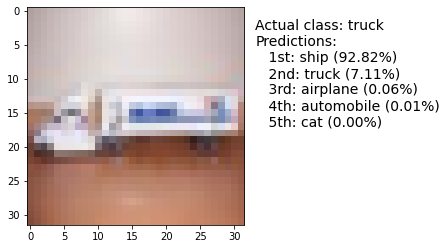

In [57]:
for key, value in results.items():
  image = X_test[key]

  actual_label = labels_word[value['Actual_class']]
  #print(f'Actual label: {actual_label}')
  predictions = value['Predictions']
  predicted_labels = []
  
  for prediction in predictions[0]:
    predicted_labels.append(labels_word[prediction])
  #print(f'Predictions: {predicted_labels}')
  percent = value['Percent']
  predicted_value = []
  for prediction in percent:
    predicted_value.append(prediction)
  textstr = '\n'.join((
    f'Actual class: {actual_label}',
    f'Predictions:',
    f'   1st: {predicted_labels[0]} ({predicted_value[0]}%)',
    f'   2nd: {predicted_labels[1]} ({predicted_value[1]}%)',
    f'   3rd: {predicted_labels[2]} ({predicted_value[2]}%)',
    f'   4th: {predicted_labels[3]} ({predicted_value[3]}%)',
    f'   5th: {predicted_labels[4]} ({predicted_value[4]}%)'))

  # plot the sample
  
  fig, ax = plt.subplots()
  ax.imshow(image, cmap='gray')
  # place a text box in upper left in axes coords
  ax.text(1.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top')
  plt.savefig(f'image_{key}.png')
  plt.show()
  